**TEAM:  Crack Pipe Burning My Hand**<br>
MEMBERS:  Kathy Adams, Danielle Castellie, Peter Mathews, John Green<br>
NOTES:  All members of the team contributed and authored this code base.  
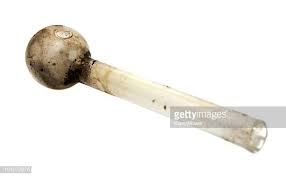

In [1]:
#Mount your google drive location.  
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Imports required before installation.  
import argparse
import sys
import os

In [3]:
#Install PYSPARK - Runs on GPU and TPU.  
!pip install pyspark
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# global setup to work around with pandas udf
!sudo pip3 install pyarrow==0.14.1
# see answers here https://stackoverflow.com/questions/58458415/pandas-scalar-udf-failing-illegalargumentexception
os.environ["ARROW_PRE_0_15_IPC_FORMAT"] = '1'

#Install pandas SQL
!pip install pandasql
!pip install pyarrow

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Created wheel for pandas-profiling: filename=pandas_profiling-2.5.3-py2.py3-none-any.whl size=239775 sha256=db6e94cb4f932aaaa4e5af1345ccb62363576eda8cc7e0cbe0669314502a4cbd
  Stored in directory: /tmp/pip-ephem-wheel-cache-0u935akc/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
Successfully built pandas-profiling
openjdk version "1.8.0_242"
OpenJDK Runtime Environment (build 1.8.0_242-8u242-b08-0ubuntu3~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.242-b08, mixed mode)


In [0]:
#All the required imports.  
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import pandasql as pdsql
import glob
from datetime import datetime
import time
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.tools.eval_measures as evalm #To compute MAE
import statsmodels.formula.api as smf  # R-like model specification
%matplotlib inline
import matplotlib.pyplot as plt  # 2D plotting
import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING

#FB PROPHET STUFF
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

#SPARK STUFF
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType, sum, max, col, concat, lit
from pyspark.sql.functions import col
import pyarrow

spark = (SparkSession
             .builder
             .appName("forecasting")
             .config('spark.sql.execution.arrow.enable', 'true')
             .getOrCreate()
             )

#PICKLE
import pickle

**USEFUL FUNCTIONS:**<br>
Developed reusable functions to utilize thorughout the data descovery and exploration process.

In [0]:
#Provide a drug name, the df to extact from, or list of columns to drop
def drugOfChoice(df, drugName = None, colsToDropList = None):
  if (colsToDropList != None):
    df = df.drop(colsToDropList)

  #Extract the wanted drug.
  if (drugName != None):
    df = df[df['DRUG_NAME'] == drugName]

  return df

**OBTAIN**<br>
Obtained a 550 million transaction data set from the Drug Enforcement Administration that had been enriched limiting the need to perform complex joines with external look up data.  <br>
Generate a supporting data set of the number of days in each month which was joined to generate metrics, such as, MME per day.  Further, the subset of data allowed us to modify each month of a year with the last day of the month.  

In [0]:
#Below, we open up the first file and scan the CSV headers.  This is to 
#understand what we are working with.  

#Get directory listing 
from glob import glob

#File paths for dope data.  
path = '/content/drive/My Drive/IST_718_Project/raw_by_drug_data/[OH]*CODONE.csv'

#File path to population data.
popFile = '/content/drive/My Drive/IST_718_Project/new_york_population.csv'

#File path to months and days data.
madFile = '/content/drive/My Drive/IST_718_Project/months_and_days.csv'

astoria_files = sorted(glob(path))
print('File Count:  ', len(astoria_files))

#Print column names
#Verify column list of each file.
for f in astoria_files:
  print(datetime.now(), 'Reading File:  ', f)
  cols = pd.read_csv(f, nrows=1, index_col=None, sep='|').columns
  print('Headers:  \n', cols)
  break

#Print column names
#Population file
popCols = pd.read_csv(popFile, nrows=1, index_col=None, sep=',').columns
print('Headers:  \n', popCols)

File Count:   2
2020-03-18 12:46:14.458327 Reading File:   /content/drive/My Drive/IST_718_Project/raw_by_drug_data/HYDROCODONE.csv
Headers:  
 Index(['REPORTER_DEA_NO', 'REPORTER_BUS_ACT', 'REPORTER_NAME',
       'REPORTER_ADDL_CO_INFO', 'REPORTER_ADDRESS1', 'REPORTER_ADDRESS2',
       'REPORTER_CITY', 'REPORTER_STATE', 'REPORTER_ZIP', 'REPORTER_COUNTY',
       'BUYER_DEA_NO', 'BUYER_BUS_ACT', 'BUYER_NAME', 'BUYER_ADDL_CO_INFO',
       'BUYER_ADDRESS1', 'BUYER_ADDRESS2', 'BUYER_CITY', 'BUYER_STATE',
       'BUYER_ZIP', 'BUYER_COUNTY', 'TRANSACTION_CODE', 'DRUG_CODE', 'NDC_NO',
       'DRUG_NAME', 'ACTION_INDICATOR', 'ORDER_FORM_NO', 'CORRECTION_NO',
       'TRANSACTION_DATE', 'TRANSACTION_ID', 'Product_Name', 'Ingredient_Name',
       'Measure', 'Combined_Labeler_Name', 'Reporter_family', 'MME'],
      dtype='object')
Headers:  
 Index(['Zip Code', 'City', 'County', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014'],
      dtype='object')


In [0]:
#Read population data.  
start_time = time.time()
print(datetime.now(), 'Reading file:  ', popFile)
popdf = pd.read_csv(popFile, index_col=None, sep=',')
popdf = popdf.rename(columns={"Zip Code":"Zip_Code"})
elapsed_time = time.time() - start_time
print(elapsed_time)

#Remove all NAs.  
for col in popdf.columns:
  popdf = popdf[popdf[col].notnull()]

#remove columns:
popdf = popdf.drop(columns=['City','County'])

display(popdf.head(5))

2020-03-18 12:46:15.992409 Reading file:   /content/drive/My Drive/IST_718_Project/new_york_population.csv
0.011671304702758789


,Zip_Code,2007,2008,2009,2010,2011,2012,2013,2014
2,6390,319.0,578.0,475.0,236.0,465.0,230.0,226.0,222.0
3,10001,20247.0,21346.0,22039.0,22575.0,23075.0,23159.0,23724.0,24091.0
4,10002,87681.0,90759.0,91474.0,81552.0,90001.0,81340.0,82039.0,82133.0
5,10003,55197.0,53718.0,54403.0,55549.0,53857.0,55827.0,56078.0,56244.0
6,10004,1864.0,2116.0,1806.0,3136.0,3773.0,3453.0,3633.0,3567.0


In [0]:
#Import months and days data to be used for normalization

#Read data.  
start_time = time.time()
print(datetime.now(), 'Reading file:  ', madFile)
maddf = pd.read_csv(madFile, index_col=None, sep=',')
elapsed_time = time.time() - start_time
print(elapsed_time)

#Convert month to string format
maddf.Month = maddf.Month.astype(str)

2020-03-18 12:46:18.983199 Reading file:   /content/drive/My Drive/IST_718_Project/months_and_days.csv
0.3130340576171875


The team did identify six columns' data types that were mixed.  
Those colomns were evaluated and identified as not problematic.    

In [0]:
#Read each txt file and put to a joined DF.  
start_time = time.time()

#Column names we care to have.  
cols = ['TRANSACTION_DATE', 'BUYER_ZIP', 'BUYER_COUNTY','DRUG_NAME',  'MME', 'BUYER_NAME', 'BUYER_ADDRESS1', 'BUYER_ADDRESS2', 'BUYER_CITY']

dfList = []  #List of df frames
#sparkDf = spark.read.csv(path, sep='|', header=True)

for f in astoria_files:
    print(datetime.now(), 'Reading file:  ', f) 
    df = pd.read_csv(f, index_col=None, sep='|', skipinitialspace=True, usecols = cols, dtype=object)
    dfList.append(df)

#DC COMMENT: why are we dropping duplicates? What does that do? Are we losing transactions?
#print(datetime.now(), 'Putting to joined dataframe.\nDropping duplicates.')
#arcos_df = pd.concat(dfList).drop_duplicates().reset_index(drop=True) #KLA changed astoria_df to arcos_df on 3/3
arcos_df = pd.concat(dfList).reset_index(drop=True)
del dfList  #Delete array to release consumed space.  

elapsed_time = time.time() - start_time
print(elapsed_time)

print('Shape of dataframe:  ',  arcos_df.shape)
display(arcos_df.head())

2020-03-18 12:46:26.034444 Reading file:   /content/drive/My Drive/IST_718_Project/raw_by_drug_data/HYDROCODONE.csv
2020-03-18 12:46:57.776802 Reading file:   /content/drive/My Drive/IST_718_Project/raw_by_drug_data/OXYCODONE.csv
61.77381420135498
Shape of dataframe:   (12286280, 9)


,BUYER_NAME,BUYER_ADDRESS1,BUYER_ADDRESS2,BUYER_CITY,BUYER_ZIP,BUYER_COUNTY,DRUG_NAME,TRANSACTION_DATE,MME
0,"CVS ALBANY, L.L.C.",320 FIFTH AVENUE,NaN,NEW YORK,10001,NEWYORK,HYDROCODONE,12042007,454.05
1,"CVS ALBANY, L.L.C.",320 FIFTH AVENUE,NaN,NEW YORK,10001,NEWYORK,HYDROCODONE,12202010,454.05
2,DUANE READE,460 8TH AVE,NaN,NEW YORK,10001,NEWYORK,HYDROCODONE,04042011,454.05
3,DUANE READE,460 8TH AVE,NaN,NEW YORK,10001,NEWYORK,HYDROCODONE,12232011,454.05
4,DUANE READE,460 8TH AVE,NaN,NEW YORK,10001,NEWYORK,HYDROCODONE,08282013,454.05


**SCRUB**<br><br>

Team did utilize a Pentaho data flow to reduce the dataset down to 21 million transaction, local to the state of New York, for all opioid types.  We decided to further reduce our analysis to the two most popular opioids, Hydrocodone and Oxycodone, and transaction type of 'S'.  This further reduced our transaction count to 12 million.  <br>

Now the data is read into a pandas dataframe.  After manual exploration and several ETL operations, we derived the following ETL process to clean the data for analytical use.  <br>

First, we remove puncuation from the drug names.  
Second, we format all dates to YYYY-MM.
Third, set the data type for MME and Zip Code.  We set zip code to string to prevent it from showing up as a numeric in discriptive statistics.  <br>
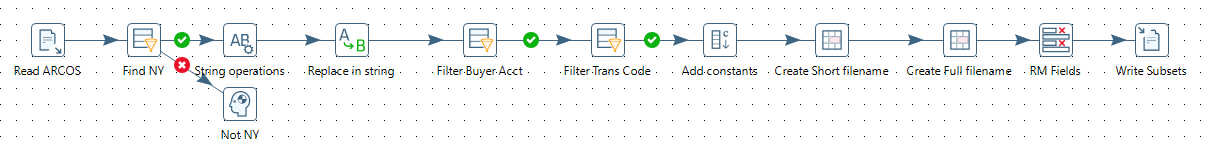

In [0]:
#CLEAN AND PREPARE DF
#Remove commas from drug names.  
def cleanOurData(df):
  #clean values.  
  df['DRUG_NAME'] = df['DRUG_NAME'].replace(',', '')
  
  #The data arrives as Monthdayyear.  I reformat to Year-Month.  
  #Did this as I noticed the transaction dates jumped arround.  
  df['TRANSACTION_DATE'] = pd.to_datetime(df['TRANSACTION_DATE'], format='%m%d%Y').dt.strftime('%Y-%m')  #The data is Monthdayyear
  df['MME'] = pd.to_numeric(arcos_df['MME'])  #We want MME as numeric.  
  df.BUYER_ZIP = df.BUYER_ZIP.astype(str)  #We want zip codes as strings.  
  
  #Adding DC's day month dataframe.  
  df['Month'] = pd.to_datetime(df['TRANSACTION_DATE']).dt.month.astype(str)
  df = df.merge(maddf,left_on='Month', right_on='Month')
  df['MMEperDay'] = df.MME / df.Days

  #added year to plot by year.  Cleaner time series.  
  df['Year'] = pd.to_datetime(df['TRANSACTION_DATE']).dt.year.astype(str)

  #Set days to string once done with calculations.  
  df.Days = df.Days.astype(str)

  #Sort the data frame on date.
  df = df.sort_values('TRANSACTION_DATE', ascending=True)

  #Get rid of 2006 data.  
  df = df[df['TRANSACTION_DATE'] >= '2007-01']
  
  df['TRANSACTION_DATE'] = df['TRANSACTION_DATE'].astype(str)
  df['TRANSACTION_DATE'] = df['TRANSACTION_DATE'] + '-' + df['Days']
  df['TRANSACTION_DATE'] = pd.to_datetime(df['TRANSACTION_DATE'], format='%Y-%m-%d')
  
  #Reset the indexes and drop them.
  df = df.reset_index(drop=True)

  return df

#start the cleaing process.  
start_time = time.time()
arcos_df = cleanOurData(arcos_df)
elapsed_time = time.time() - start_time
print(elapsed_time)
del df  #Remove to save space.  

display(arcos_df.head(5))

188.5118384361267


,BUYER_NAME,BUYER_ADDRESS1,BUYER_ADDRESS2,BUYER_CITY,BUYER_ZIP,BUYER_COUNTY,DRUG_NAME,TRANSACTION_DATE,MME,Month,Days,MMEperDay,Year
0,SWAMI NARAYAN PHARMACY INC,3457 BOSTON RD,NaN,BRONX,10469,BRONX,HYDROCODONE,2007-01-31,2270.250,1,31,73.233871,2007
1,LORAUL PHARMACEUTICS INC,81 MAIN STREET,NaN,BATAVIA,14020,GENESEE,HYDROCODONE,2007-01-31,2270.250,1,31,73.233871,2007
2,"GENOVESE DRUG STORES, INC.",395 FORT SALONGA ROAD,NaN,NORTHPORT,11768,SUFFOLK,OXYCODONE,2007-01-31,672.375,1,31,21.689516,2007
3,"JEMJAY DRUG, INC",224-12 MERRICK BLVD,NaN,LAURELTON,11413,QUEENS,OXYCODONE,2007-01-31,4034.250,1,31,130.137097,2007
4,"KPH HEALTHCARE SERVICES, INC.",17 CLINTON STREET,NaN,GOUVERNEUR,13642,SAINTLAWRENCE,HYDROCODONE,2007-01-31,3632.400,1,31,117.174194,2007


After scrubbing the data, we write the data to two format types, parquet and CSV.  The team utilized parquet to support the utilization of Spark for data exploration.  The CSV version of the scrubbed data was used to support the Tableau dashboard and RAPIDS modeling.<br>
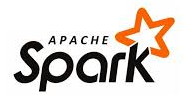
<br>
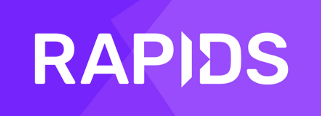<br>
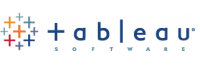

In [0]:
#Put to an arrow table
#Push table to file system.
dopeTable = pa.Table.from_pandas(arcos_df)
pq.write_table(dopeTable, '/content/drive/My Drive/IST_718_Project/parquet/clean_drugs.parquet')

In [0]:
#To support RAPIDS integration and Tableau
path = '/content/drive/My Drive/IST_718_Project/ETL/clean_drugs.csv'
arcos_df.to_csv(path)

**EXPLORE** - *DESCRIPTIVE STATISTICS:*<BR>
Now the team has the scrubbed data written to file, we no longer have to run the scrub processing to begin exploritory data analysis (EDA).  

The descriptive statistics below identified the following.  


*   New York state received an average of 4100.06 MME over 8 years.  Breaking down by day, averaged 134.79 per day.  
*   CVS Pharmacy account for the majority of the transactions.  This we would expect.  However, we have identified over three thousand unique pharmacies.  
*   It is evident most transactions are for Hydrocodone.  
*   Majority of the transactions are in 2011.

In [0]:
#Describe each object in dataframe to get basic stats.  
display(arcos_df.describe(include=[np.number]))  #Numerical stats.
display(arcos_df.describe(include=[np.object]))  #Categorical stats.

,MME,MMEperDay
count,1.114300e+07,1.114300e+07
mean,4.100059e+03,1.347885e+02
std,8.495990e+03,2.795461e+02
min,1.513500e+00,4.882258e-02
25%,6.723750e+02,2.241250e+01
50%,2.017125e+03,6.723750e+01
75%,4.034250e+03,1.344750e+02
max,1.721280e+06,5.552516e+04


,BUYER_NAME,BUYER_ADDRESS1,BUYER_ADDRESS2,BUYER_CITY,BUYER_ZIP,BUYER_COUNTY,DRUG_NAME,Month,Days,Year
count,11142997,11142997,2329050,11142997,11142997,11142997,11142997,11142997,11142997,11142997
unique,3859,5813,904,750,877,61,2,12,3,8
top,"CVS ALBANY, L.L.C.",ATTN: PHARMACY,ATTN: PHARMACY,NEW YORK,14043,SUFFOLK,HYDROCODONE,12,31,2011
freq,1378928,101194,487429,796965,79191,1084234,5793043,963610,6629049,1496402


**EXPLORATORY ANALYSIS**<br>

In [0]:
#Read the parquet file.  
parquetFile = spark.read.parquet("/content/drive/My Drive/IST_718_Project/parquet/clean_drugs.parquet")

#Temp view for stats
parquetFile.createOrReplaceTempView("drugmme")

The team normalized all transactions to monthly to rid the random day ranges witin each month.  Further, the team added the last day onto the normalized months to prepare for predictive model generation.  The bar plot below was to confirm if there was uniformity accross the months.  

(96, 2)


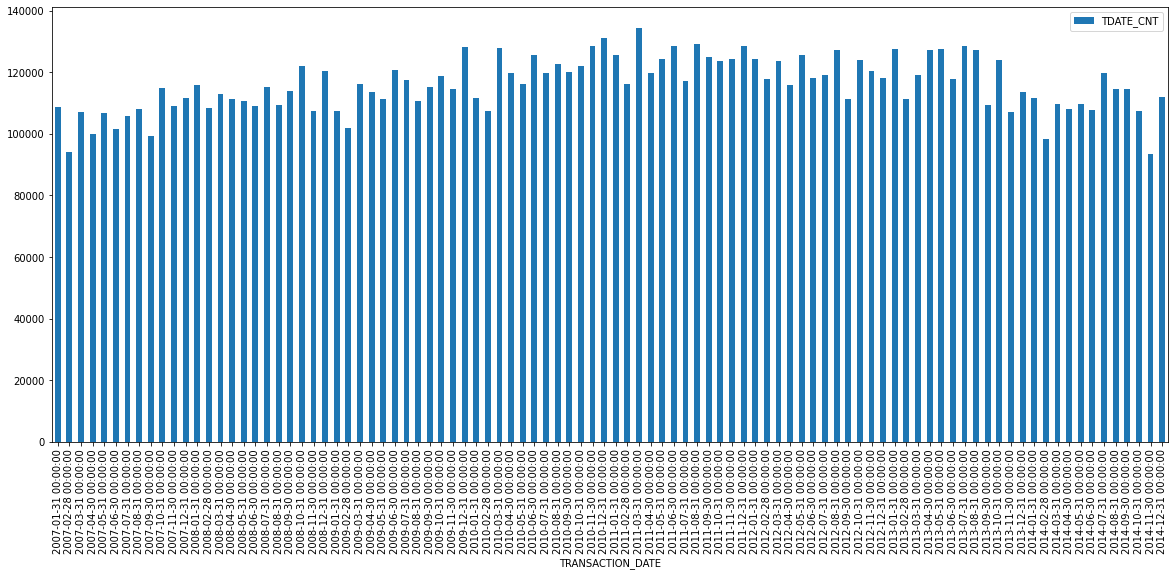

In [0]:
#Select distinct buyer names.  
query = 'select TRANSACTION_DATE, COUNT(TRANSACTION_DATE) AS TDATE_CNT from drugmme group by TRANSACTION_DATE order by TRANSACTION_DATE asc'
df = spark.sql(query)
df = df.toPandas()
print(df.shape)

df.plot.bar(x='TRANSACTION_DATE', y='TDATE_CNT', figsize=(20,8))

The first important observation made by the team was how much MME was being aquired for both Hydrocodone and Oxycodone.  Further, the team wanted an understanding of how this was spread across by transaction.  

+-----------+---------+---------+------------------+--------------------+
|  DRUG_NAME|  MAX_MME|  MIN_MME|           AVG_MME|           MME_TOTAL|
+-----------+---------+---------+------------------+--------------------+
|HYDROCODONE| 622048.5|   1.5135|1661.8081748120517| 9.626926214437733E9|
|  OXYCODONE|1721280.0|18.154125| 6740.248085496782|3.606001720599585E10|
+-----------+---------+---------+------------------+--------------------+



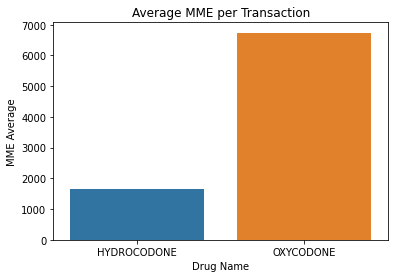

In [0]:
#MME Total by drug name
query = 'select DRUG_NAME, max(MME) AS MAX_MME, min(MME) as MIN_MME, avg(MME) as AVG_MME, sum(MME) AS MME_TOTAL from drugmme group by DRUG_NAME order by SUM(MME)'
df = spark.sql(query)
df.show()

df = df.toPandas()
ax = sns.barplot(x="DRUG_NAME", y="AVG_MME", data=df)
plt.title('Average MME per Transaction')
plt.xlabel('Drug Name')
plt.ylabel('MME Average')
plt.show()

+-----------+-----------------+
|  DRUG_NAME|TRANSACTION_COUNT|
+-----------+-----------------+
|HYDROCODONE|          5793043|
|  OXYCODONE|          5349954|
+-----------+-----------------+



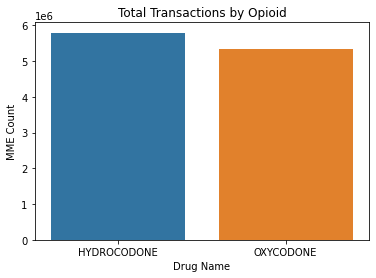

+-----------+--------------------+
|  DRUG_NAME|           MME_TOTAL|
+-----------+--------------------+
|HYDROCODONE| 9.626926214437733E9|
|  OXYCODONE|3.606001720599585E10|
+-----------+--------------------+



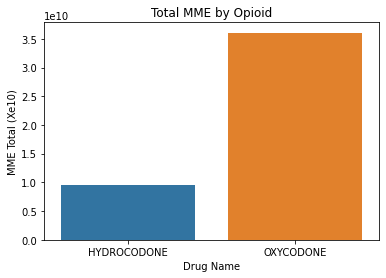

In [0]:
#Bar plot of Drug Names
#Transaction count by drug name
query = 'select DRUG_NAME, count(DRUG_NAME) AS TRANSACTION_COUNT from drugmme group by DRUG_NAME'
df = spark.sql(query)
df.show()

df = df.toPandas()
ax = sns.barplot(x="DRUG_NAME", y="TRANSACTION_COUNT", data=df)
plt.title('Total Transactions by Opioid')
plt.xlabel('Drug Name')
plt.ylabel('MME Count')
plt.show()

#MME Total by drug name
query = 'select DRUG_NAME, sum(MME) AS MME_TOTAL from drugmme group by DRUG_NAME order by SUM(MME)'
df1 = spark.sql(query)
df1.show()

df1 = df1.toPandas()
ax = sns.barplot(x="DRUG_NAME", y="MME_TOTAL", data=df1)
plt.title('Total MME by Opioid')
plt.xlabel('Drug Name')
plt.ylabel('MME Total (Xe10)')
plt.show()

*MME Growth Y-o-Y* <br>
To understand the opioid problem at hand in New York, we utilized a bar lot to get an understanding of the year-over-year growth rates of both Hydrocodone and Oxycodone.  <BR>
It is evident New York state favors Oxycodone over Hydrocodone even though Hydrocodone accounts for the majority of the transactions.  One intresting note to make, the MME aquisition of Hydrocodone has been reducing since 2011. 

(16, 3)


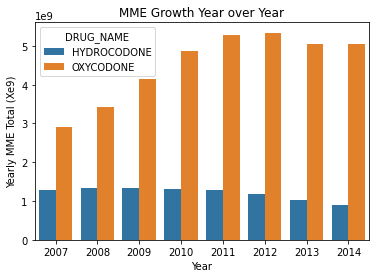

In [0]:
#Select distinct buyer names.  
query = 'select Year, DRUG_NAME, sum(MME) as Yearly_Total from drugmme group by Year, DRUG_NAME order by Year asc'
df = spark.sql(query)
df = df.toPandas()
print(df.shape)

ax = sns.barplot(x="Year", y="Yearly_Total", hue="DRUG_NAME", data=df)
plt.title('MME Growth Year over Year')
plt.ylabel('Yearly MME Total (Xe9)')
plt.show()

(16, 3)


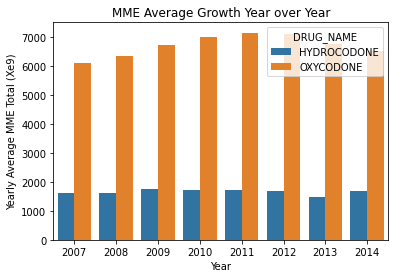

In [0]:
#Select distinct buyer names.  
#Chart average MME growth per transaction Y-o-Y.
query = 'select Year, DRUG_NAME, avg(MME) as YRLY_AVG_MME from drugmme group by Year, DRUG_NAME order by Year asc'
df = spark.sql(query)
df = df.toPandas()
print(df.shape)

ax = sns.barplot(x="Year", y="YRLY_AVG_MME", hue="DRUG_NAME", data=df)
plt.title('MME Average Growth Year over Year')
plt.ylabel('Yearly Average MME Total (Xe9)')
plt.show()

The team then wanted to get an idea of how MME of both opioids was distrbuted across the counties.  

In [0]:
query = 'select BUYER_COUNTY, max(MME) AS MAX_MME, min(MME) as MIN_MME, avg(MME) as AVG_MME, sum(MME) as MME_TOTAL from drugmme group by BUYER_COUNTY order by sum(MME) desc'
df = spark.sql(query)
df.show()

df = df.toPandas()
display(df.head(10))

+------------+------------------+------------------+------------------+--------------------+
|BUYER_COUNTY|           MAX_MME|           MIN_MME|           AVG_MME|           MME_TOTAL|
+------------+------------------+------------------+------------------+--------------------+
|     SUFFOLK|          387288.0|            1.5135| 4574.937664943601|4.9603029642124605E9|
|     NEWYORK|         1721280.0|3.0269999999999997| 5295.792639876819|4.2662058180025268E9|
|      NASSAU|         1331302.5|3.0269999999999997| 5214.315995369189|4.1938013546515036E9|
|       KINGS|         1290960.0|            1.5135| 4560.183877915043|3.4339780665057545E9|
|        ERIE|          258192.0|            1.5135|3444.1075495093087| 2.956201497615622E9|
|      QUEENS|          242055.0|3.0269999999999997| 4034.253726120591| 2.905917335715649E9|
|       BRONX|         1032768.0|3.0269999999999997| 6421.019501380457| 2.865739529583106E9|
|    RICHMOND|          605137.5|3.0269999999999997| 7719.224703442687

,BUYER_COUNTY,MAX_MME,MIN_MME,AVG_MME,MME_TOTAL
0,SUFFOLK,3.872880e+05,1.5135,4574.937665,4.960303e+09
1,NEWYORK,1.721280e+06,3.0270,5295.792640,4.266206e+09
2,NASSAU,1.331302e+06,3.0270,5214.315995,4.193801e+09
3,KINGS,1.290960e+06,1.5135,4560.183878,3.433978e+09
4,ERIE,2.581920e+05,1.5135,3444.107550,2.956201e+09
5,QUEENS,2.420550e+05,3.0270,4034.253726,2.905917e+09
6,BRONX,1.032768e+06,3.0270,6421.019501,2.865740e+09
7,RICHMOND,6.051375e+05,3.0270,7719.224703,2.153054e+09
8,MONROE,1.075800e+06,1.5135,3417.118772,1.857764e+09
9,WESTCHESTER,3.387402e+05,3.0270,3619.876447,1.659815e+09


+------------+-----------+--------------------+
|BUYER_COUNTY|  DRUG_NAME|           MME_TOTAL|
+------------+-----------+--------------------+
|     SUFFOLK|  OXYCODONE|4.0261252275466766E9|
|     NEWYORK|  OXYCODONE| 3.922073728641394E9|
|      NASSAU|  OXYCODONE|3.6765492710991373E9|
|       KINGS|  OXYCODONE|3.0512369307434025E9|
|       BRONX|  OXYCODONE| 2.674269557856434E9|
|      QUEENS|  OXYCODONE|2.5110216165427012E9|
|    RICHMOND|  OXYCODONE|1.9487853636529913E9|
|        ERIE|  OXYCODONE| 1.508947204829822E9|
|        ERIE|HYDROCODONE|1.4472542927841635E9|
|      MONROE|  OXYCODONE|1.4148735415677464E9|
| WESTCHESTER|  OXYCODONE|1.3840349502733655E9|
|      ORANGE|  OXYCODONE|1.0039377781033005E9|
|     SUFFOLK|HYDROCODONE| 9.341777366637774E8|
|    ONONDAGA|  OXYCODONE| 8.258030834687858E8|
|    DUTCHESS|  OXYCODONE| 7.107533241452019E8|
|    ROCKLAND|  OXYCODONE|  6.53785877474493E8|
|      NASSAU|HYDROCODONE| 5.172520835525337E8|
|      BROOME|  OXYCODONE|  4.6982693840

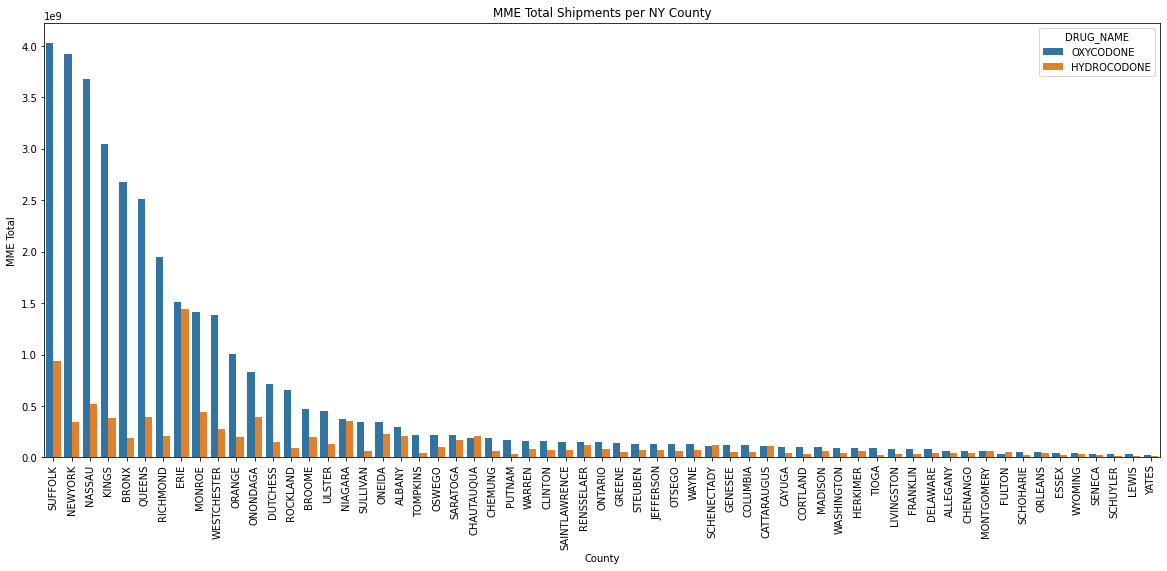

In [0]:
query = 'select BUYER_COUNTY, DRUG_NAME, sum(MME) as MME_TOTAL from drugmme group by BUYER_COUNTY, DRUG_NAME order by sum(MME) desc'
df = spark.sql(query)
df.show()
df = df.toPandas()

plt.figure(figsize=(20,8))
ax = sns.barplot(x="BUYER_COUNTY", y="MME_TOTAL", hue="DRUG_NAME", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('County')
ax.set_ylabel('MME Total')
ax.set_title('MME Total Shipments per NY County')
plt.show()



+------------+---------+------------------+
|BUYER_COUNTY|DRUG_NAME|           MME_AVG|
+------------+---------+------------------+
|    RICHMOND|OXYCODONE|11934.212914454856|
|       BRONX|OXYCODONE| 9328.283259116079|
|    ROCKLAND|OXYCODONE| 8723.775102070815|
|      NASSAU|OXYCODONE| 8591.212547229741|
|    SULLIVAN|OXYCODONE|  8433.38150483342|
|       TIOGA|OXYCODONE| 8397.905159114742|
|     NEWYORK|OXYCODONE| 8081.234721543429|
|    COLUMBIA|OXYCODONE| 7587.437402967293|
|     SUFFOLK|OXYCODONE| 7540.266368661254|
|   SCHOHARIE|OXYCODONE| 7333.842137029508|
|    DELAWARE|OXYCODONE| 7052.150283367565|
|      ORANGE|OXYCODONE|  7010.05333349603|
|    DUTCHESS|OXYCODONE|  6853.34275853785|
|       KINGS|OXYCODONE| 6849.339544048996|
|      BROOME|OXYCODONE| 6574.224283269782|
|      GREENE|OXYCODONE| 6430.781567372626|
|      ULSTER|OXYCODONE| 6381.536051569815|
|      QUEENS|OXYCODONE| 6357.499598811812|
|      WARREN|OXYCODONE| 6313.888733963468|
| WESTCHESTER|OXYCODONE| 6062.53

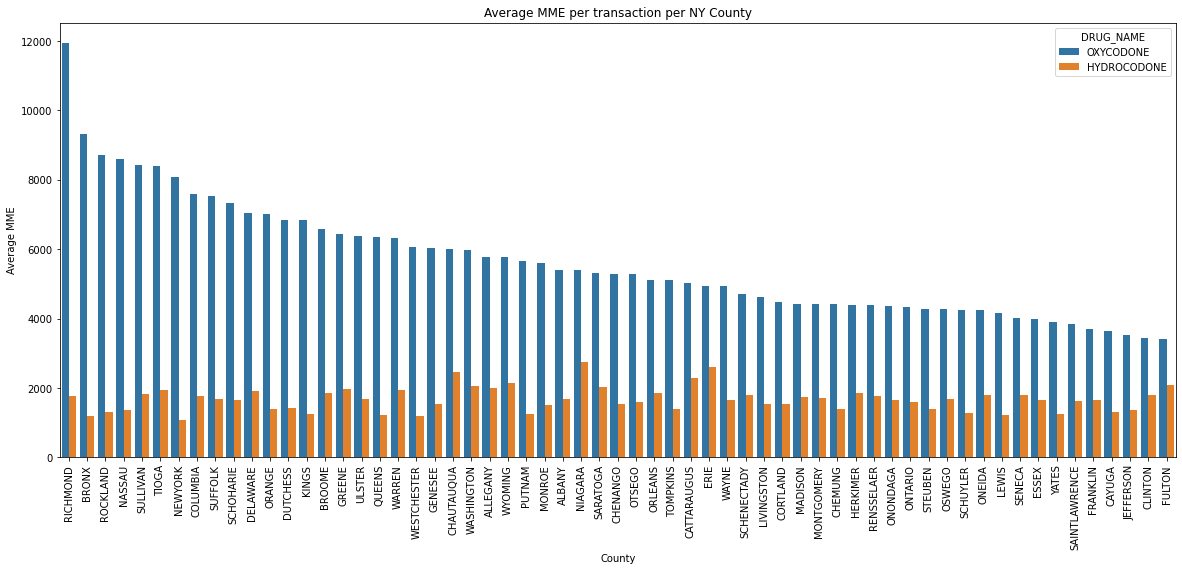

In [0]:
query = 'select BUYER_COUNTY, DRUG_NAME, avg(MME) as MME_AVG from drugmme group by BUYER_COUNTY, DRUG_NAME order by avg(MME) desc'
df = spark.sql(query)
df.show()
df = df.toPandas()

plt.figure(figsize=(20,8))
ax = sns.barplot(x="BUYER_COUNTY", y="MME_AVG", hue="DRUG_NAME", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('County')
ax.set_ylabel('Average MME')
ax.set_title('Average MME per transaction per NY County')
plt.show()

Historgram showing the top zip codes by MME shipment.  

+---------+--------------------+
|BUYER_ZIP|           MME_TOTAL|
+---------+--------------------+
|    11784| 3.961751785269879E8|
|    10305| 3.894348062571587E8|
|    10467| 3.602267472597184E8|
|    11561| 3.456185733577715E8|
|    10451| 3.375336503223545E8|
|    10306| 3.339558205541312E8|
|    10010|3.1791775889437604E8|
|    10940|3.1216084090942436E8|
|    10314| 2.993207032480541E8|
|    10021| 2.925996903735855E8|
|    10312| 2.889316098554242E8|
|    10003| 2.826930396623069E8|
|    14224|2.7775589257216895E8|
|    12401| 2.707457908224437E8|
|    11706|2.6801553527105227E8|
|    11223|2.6031738892838788E8|
|    10458|2.6031267311349687E8|
|    11791| 2.400062845928821E8|
|    11209|2.3695204741242024E8|
|    10019|2.3510097211112145E8|
+---------+--------------------+
only showing top 20 rows



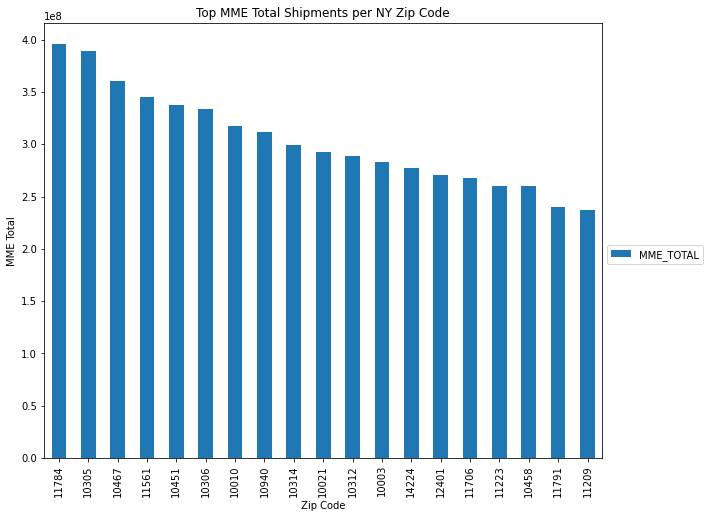

In [0]:
query = 'select BUYER_ZIP, sum(MME) as MME_TOTAL from drugmme group by BUYER_ZIP order by sum(MME) desc'
df = spark.sql(query)
df.show()

#Plot only the top mme totals.
df = df.toPandas()
df = df[df['MME_TOTAL'] > 2.3510097211112145E8]

ax = df.plot.bar(x='BUYER_ZIP', y = 'MME_TOTAL', rot = 90, figsize=(10,8))
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5), ncol = 1)
ax.set_xlabel('Zip Code')
ax.set_ylabel('MME Total')
ax.set_title('Top MME Total Shipments per NY Zip Code')
plt.show()

Bar plot of the top drugs by MME total shipped.  <br>
It is evident Oxycodone is favored over Hydrocodone in the state of New York.  

To discover the population of buyers<br>
The histogram below shows the top 50 buyers of opioids by the number of transactions represented in the population.  Based the top 50 on those with at least or more than 10,000 transactions.  

+--------------------+---------+
|          BUYER_NAME|BUYER_CNT|
+--------------------+---------+
|  CVS ALBANY, L.L.C.|  1378928|
|RITE AID OF NEW Y...|   774652|
|WALGREEN EASTERN ...|   682250|
|  ECKERD CORPORATION|   624935|
|WEGMANS FOOD MARK...|   476991|
|KPH HEALTHCARE SE...|   412283|
|         DUANE READE|   313251|
|GENOVESE DRUG STO...|   254977|
|        TOPS MARKETS|   173151|
|THE GOLUB CORPORA...|   135986|
|     PATHMARK STORES|   100619|
|MARTIN'S FOODS OF...|    99450|
|TARGET STORES A D...|    88825|
|  K MART CORPORATION|    40003|
|THE STOP & SHOP S...|    38442|
|WALGREEN EASTERN ...|    38191|
|WEGMANS FOOD MARK...|    35222|
|            WALDBAUM|    32284|
|   KMART CORPORATION|    32038|
|   TOPS MARKETS, LLC|    28850|
+--------------------+---------+
only showing top 20 rows

(11, 2)


Text(0.5, 1.0, 'Transaction Distribution of Buyers above 100K')

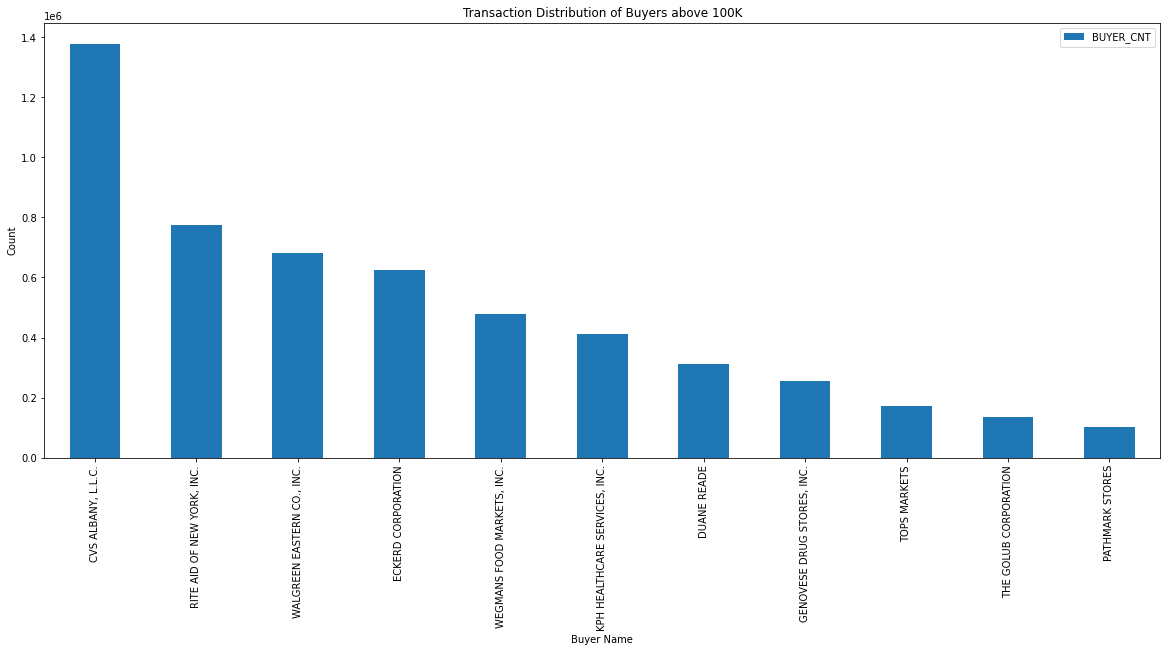

In [0]:
#Select distinct buyer names.  
query = 'select BUYER_NAME, count(BUYER_NAME) as BUYER_CNT from drugmme group by BUYER_NAME order by count(BUYER_NAME) desc'
df = spark.sql(query)
df.show()
df = df.toPandas()
df = df[df['BUYER_CNT'] >= 100000]
print(df.shape)


ax = df.plot.bar(x='BUYER_NAME', y='BUYER_CNT', figsize=(20,8))
plt.xlabel('Buyer Name')
plt.ylabel('Count')
plt.title('Transaction Distribution of Buyers above 100K')

#path = '/content/drive/My Drive/IST_718_Project/ETL/buyer_names.csv'
#df.toPandas().to_csv(path)

Top 20 buying companies by MME total.  

In [0]:
#Top 20 companies by MME
query = 'select BUYER_NAME, BUYER_CITY, BUYER_ZIP, sum(MME) as MME_TOTAL from drugmme GROUP BY BUYER_NAME, BUYER_CITY, BUYER_ZIP order by sum(MME) desc'
df = spark.sql(query)
df.show()

+--------------------+--------------+---------+--------------------+
|          BUYER_NAME|    BUYER_CITY|BUYER_ZIP|           MME_TOTAL|
+--------------------+--------------+---------+--------------------+
|PROHEALTH PHARMAC...|      NEW YORK|    10010| 2.021241562039256E8|
|RUPAL ENTERPRISE INC|        SELDEN|    11784|1.8592067253479153E8|
|    LINDEN CARE, LLC|       SYOSSET|    11791|1.6099631568728605E8|
| 161 ST PHARMACY INC|         BRONX|    10451|1.4712554810441533E8|
|OCEAN BREEZE ASSO...| STATEN ISLAND|    10305|1.4574315503989583E8|
|LEVIN'S PHARMACY INC|     OCEANSIDE|    11572|1.3950482984334058E8|
|THIRD AVENUE LERM...|      NEW YORK|    10021|1.2411250075444846E8|
|         DUANE READE|      NEW YORK|    10003|1.1887716050382648E8|
|MIDDLETOWN APOTHE...|    MIDDLETOWN|    10940|1.1423833936573547E8|
|R & M DRUG CORPOR...|     GLEN OAKS|    11004| 1.138052603536346E8|
|RITE AID OF NEW Y...|      LOCKPORT|    14094|1.0886494197323334E8|
|WALGREEN EASTERN ...|        SELD

**STARTING TIME SERIES ANALYSIS - SPARK & FB PROPHET**

Read in the parque data file generated by the ETL process and select the column values wanted.  Display the results.  
Create the view, cleandrugs, for query.  From this we build our time series results.  

In [7]:
# Read in the Parquet file created above.
# Parquet files are self-describing so the schema is preserved.
# The result of loading a parquet file is also a DataFrame.
parquetFile = spark.read.parquet("/content/drive/My Drive/IST_718_Project/parquet/clean_drugs.parquet")

# Parquet files can also be used to create a temporary view and then used in SQL statements.
parquetFile.createOrReplaceTempView("cleandrugs")
cleandrugsDf = spark.sql("SELECT BUYER_ZIP, BUYER_COUNTY, TRANSACTION_DATE, MME, MMEperDay FROM cleandrugs")
cleandrugsDf.show()

+---------+-------------+-------------------+------------------+------------------+
|BUYER_ZIP| BUYER_COUNTY|   TRANSACTION_DATE|               MME|         MMEperDay|
+---------+-------------+-------------------+------------------+------------------+
|    10469|        BRONX|2007-01-31 00:00:00|           2270.25| 73.23387096774194|
|    14020|      GENESEE|2007-01-31 00:00:00|           2270.25| 73.23387096774194|
|    11768|      SUFFOLK|2007-01-31 00:00:00|           672.375| 21.68951612903226|
|    11413|       QUEENS|2007-01-31 00:00:00|           4034.25|130.13709677419354|
|    13642|SAINTLAWRENCE|2007-01-31 00:00:00|            3632.4| 117.1741935483871|
|    10977|     ROCKLAND|2007-01-31 00:00:00|           2270.25| 73.23387096774194|
|    13088|     ONONDAGA|2007-01-31 00:00:00|            1513.5| 48.82258064516129|
|    11720|      SUFFOLK|2007-01-31 00:00:00|            1344.6| 43.37419354838709|
|    10019|      NEWYORK|2007-01-31 00:00:00|           64548.0|2082.1935483

+------------+-------------------+------------------+
|BUYER_COUNTY|   TRANSACTION_DATE|               MME|
+------------+-------------------+------------------+
|     SUFFOLK|2007-01-31 00:00:00|           672.375|
|      QUEENS|2007-01-31 00:00:00|           4034.25|
|     SUFFOLK|2007-01-31 00:00:00|            1344.6|
|     NEWYORK|2007-01-31 00:00:00|           64548.0|
|      QUEENS|2007-01-31 00:00:00|            454.05|
|      NASSAU|2007-01-31 00:00:00|1210.8000000000004|
|     SUFFOLK|2007-01-31 00:00:00| 605.4000000000002|
|      QUEENS|2007-01-31 00:00:00|           2270.25|
|      QUEENS|2007-01-31 00:00:00|         572.92207|
|       KINGS|2007-01-31 00:00:00|           672.375|
|      NASSAU|2007-01-31 00:00:00|            4540.5|
|     SUFFOLK|2007-01-31 00:00:00|        286.461035|
|     NEWYORK|2007-01-31 00:00:00|            1513.5|
|      NASSAU|2007-01-31 00:00:00|            454.05|
|      QUEENS|2007-01-31 00:00:00| 719.3610000000001|
|     SUFFOLK|2007-01-31 00:

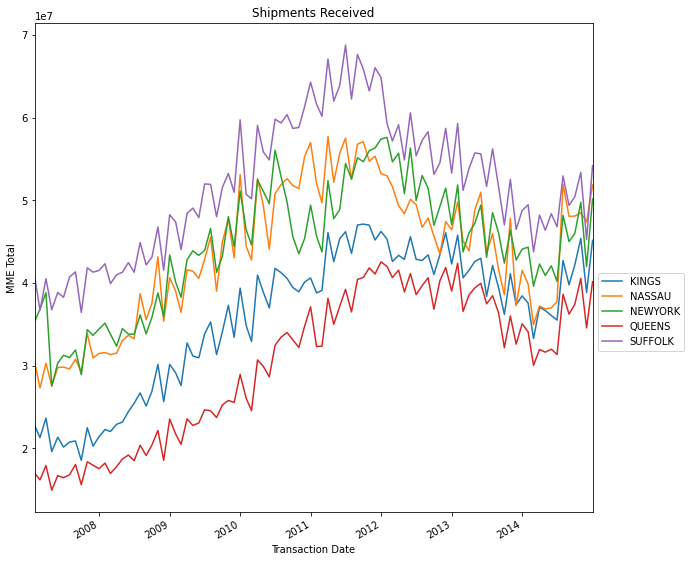

In [8]:
#Set up data frame for time series
#Top 5 counties.  
query = 'select BUYER_COUNTY, TRANSACTION_DATE, MME from cleandrugs where BUYER_COUNTY IN ("SUFFOLK", "NASSAU", "NEWYORK", "KINGS", "QUEENS")'
df = spark.sql(query)
df.show()

#Pivot table by county.
df = df.groupBy("TRANSACTION_DATE").pivot("BUYER_COUNTY").sum("MME")
df = df.orderBy("TRANSACTION_DATE")
df.show()

ax = df.toPandas().set_index("TRANSACTION_DATE").plot(figsize=(10, 10))
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5), ncol = 1)
ax.set_xlabel('Transaction Date')
ax.set_ylabel('MME Total')
ax.set_title('Shipments Received')
plt.show()

**GROWTH RATE PREDICTION** - *FB Prophet*<br>
The team utilized Facebook's Prophet to predict the month-over-month growht rate of each opioid, Hydrocodone and Oxycodone.  



In [0]:
#SQL statement for walking through each zip code, summing the MME and submitting
#to FB Prophet.  
sql_statement = '''
  SELECT BUYER_ZIP as Zip, TRANSACTION_DATE as ds, sum(MME) as y
  FROM cleandrugs
  GROUP BY BUYER_ZIP, TRANSACTION_DATE
  ORDER BY BUYER_ZIP, TRANSACTION_DATE
  '''

sc = spark.sparkContext

zip_history = (
  spark
    .sql( sql_statement )
    .repartition(sc.defaultParallelism, ['Zip'])
  ).cache()

Query the clean drugs view to sum the MME per Day values and submit to the Prophet that knows all.  :)

In [0]:
#SQL statement for walking through each zip code, summing the MME per day and submitting
#to FB Prophet.  
sql_statement = '''
  SELECT BUYER_ZIP as Zip, TRANSACTION_DATE as ds, sum(MMEperDay) as y
  FROM cleandrugs
  GROUP BY BUYER_ZIP, TRANSACTION_DATE
  ORDER BY BUYER_ZIP, TRANSACTION_DATE
  '''

sc = spark.sparkContext

zip_history = (
  spark
    .sql( sql_statement )
    .repartition(sc.defaultParallelism, ['Zip'])
  ).cache()

Creating the result schema for spark

In [0]:
result_schema =StructType([
  StructField('ds',DateType()),
  StructField('Zip',StringType()),
  StructField('y',FloatType()),
  StructField('yhat',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('yhat_lower',FloatType()),
  StructField('mom_growth',FloatType())
  ])

In [0]:
@pandas_udf( result_schema, PandasUDFType.GROUPED_MAP )
def forecast_zip( history_pd ):
  
  # TRAIN MODEL AS BEFORE
  # --------------------------------------
 
  # configure the FB Prophet model
  model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
    )
  
  # train the model
  model.fit( history_pd )
  # --------------------------------------
  
  # BUILD FORECAST AS BEFORE
  # --------------------------------------
  # make predictions
  future_pd = model.make_future_dataframe(
    periods=12, 
    freq='m', 
    include_history=True
    )
  
  #DC COMMENT: THE DATES SWITCH FROM BEGINNING OF MONTH TO END OF MONTH
  # CAN WE EDIT THE DATES TO MAKE THEM BEGINNING OF MONTH FOR ONLY THE LAST TWELVE DATES?

  forecast_pd = model.predict( future_pd )  
  forecast_pd['mom_growth']= (forecast_pd['yhat'] / forecast_pd['yhat'].shift(1))-1

  # --------------------------------------
  
  # ASSEMBLE EXPECTED RESULT SET
  # --------------------------------------
  # get relevant fields from forecast
  f_pd = forecast_pd[ ['ds','yhat', 'yhat_upper', 'yhat_lower', 'mom_growth'] ].set_index('ds')
  
  # get relevant fields from history
  h_pd = history_pd[['ds','Zip','y']].set_index('ds')
  
  # join history and forecast
  results_pd = f_pd.join( h_pd, how='left' )
  results_pd.reset_index(level=0, inplace=True)
  
  # get Zip from incoming data set
  results_pd['Zip'] = history_pd['Zip'].iloc[0]
  # --------------------------------------
  
  # return expected dataset
  return results_pd[ ['ds', 'Zip', 'y', 'yhat', 'yhat_upper', 'yhat_lower', 'mom_growth'] ]  

In [0]:
# Run forecasting models for all zip codes with data from 2007-2017
%%time
results = (
  zip_history
    .groupBy('Zip')
    .apply(forecast_zip)
    .repartition(sc.defaultParallelism, ['Zip'])
    ).na.fill(0).cache()

results.show(20)
results.createOrReplaceTempView('results')

+----------+-----+---------+---------+----------+----------+------------+
|        ds|  Zip|        y|     yhat|yhat_upper|yhat_lower|  mom_growth|
+----------+-----+---------+---------+----------+----------+------------+
|2007-01-31|10301|22086.236|17436.291| 29050.156| 6148.1016|         0.0|
|2007-02-28|10301| 29689.55|19794.701| 31289.957|    8598.6|  0.13525872|
|2007-03-31|10301|16243.479|21351.828|  32698.33|  9335.169| 0.078663856|
|2007-04-30|10301|15501.518|19113.617| 31035.922|  8447.993|-0.104825325|
|2007-05-31|10301|16640.072|18206.154| 28901.705|  7438.135|-0.047477223|
|2007-06-30|10301| 19658.19|20410.861| 31820.855|  9162.798| 0.121096715|
|2007-07-31|10301|21810.717|20112.875| 31199.195|  9259.477|-0.014599355|
|2007-08-31|10301| 17376.62| 20027.31| 32419.305|  7464.954|-0.004254249|
|2007-09-30|10301|20135.656|22389.197|  34206.15|  11216.37|  0.11793337|
|2007-10-31|10301|24660.873|25865.719|  37366.78| 14354.402|  0.15527673|
|2007-11-30|10301|20663.475|20663.217|

In [0]:
#Verify the results and dates.  
df = results.toPandas()
display(df.head(20))
display(df.tail(20))

,ds,Zip,y,yhat,yhat_upper,yhat_lower,mom_growth
0,2007-01-31,10301,22086.236328,17436.291016,29050.156250,6148.101562,0.000000
1,2007-02-28,10301,29689.550781,19794.701172,31289.957031,8598.599609,0.135259
2,2007-03-31,10301,16243.478516,21351.828125,32698.330078,9335.168945,0.078664
3,2007-04-30,10301,15501.517578,19113.617188,31035.921875,8447.993164,-0.104825
4,2007-05-31,10301,16640.072266,18206.154297,28901.705078,7438.134766,-0.047477
5,2007-06-30,10301,19658.189453,20410.861328,31820.855469,9162.797852,0.121097
6,2007-07-31,10301,21810.716797,20112.875000,31199.195312,9259.476562,-0.014599
7,2007-08-31,10301,17376.619141,20027.310547,32419.304688,7464.954102,-0.004254
8,2007-09-30,10301,20135.656250,22389.197266,34206.148438,11216.370117,0.117933
9,2007-10-31,10301,24660.873047,25865.718750,37366.781250,14354.402344,0.155277


,ds,Zip,y,yhat,yhat_upper,yhat_lower,mom_growth
91447,2014-04-30,14853,50.450001,64.576485,168.986313,-48.922085,0.276108
91448,2014-06-30,14853,50.450001,9.595571,120.463860,-95.575378,-0.851408
91449,2014-07-31,14853,21.689516,6.318852,119.499855,-104.689651,-0.341482
91450,2014-08-31,14853,43.379032,31.472040,131.984695,-72.233299,3.980658
91451,2014-09-30,14853,201.220001,33.377110,147.442642,-81.986176,0.060532
91452,2014-10-31,14853,43.379032,30.989445,140.916168,-73.695007,-0.071536
91453,2014-11-30,14853,22.412500,49.268154,148.518311,-60.896862,0.589837
91454,2014-12-31,14853,60.747581,19.303968,124.429802,-87.208527,-0.608186
91455,2015-01-31,14853,0.000000,16.704966,123.032379,-85.029274,-0.134636
91456,2015-02-28,14853,0.000000,23.819382,131.900864,-83.622818,0.425886


In [0]:
path = '/content/drive/My Drive/IST_718_Project/Forecast_Results/forecast_model_MMEperDay.csv'
df = results.toPandas()
df.to_csv(path)

After creating our FB predictions, Crack Pipe Burning my Hand computes the prediction error below.

In [0]:
#Compute the error of our time series predictions on MME M-o-M Growth.
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from datetime import date

# schema of expected result set
eval_schema =StructType([
  StructField('Zip', StringType()),
  StructField('mae', FloatType()),
  StructField('mse', FloatType()),
  StructField('rmse', FloatType())
  ])

# define udf to calculate metrics
@pandas_udf( eval_schema, PandasUDFType.GROUPED_MAP )
def evaluate_forecast( evaluation_pd ):
  
  # get store & item in incoming data set
  Zip = evaluation_pd['Zip'].iloc[0]
  
  # calulate evaluation metrics
  mae = mean_absolute_error( evaluation_pd['y'], evaluation_pd['yhat'] )
  mse = mean_squared_error( evaluation_pd['y'], evaluation_pd['yhat'] )
  rmse = sqrt( mse )
  
  # assemble result set
  results = {'Zip':[Zip], 'mae':[mae], 'mse':[mse], 'rmse':[rmse]}
  return pd.DataFrame.from_dict( results )


# calculate metrics
eval_results = (
  spark
    .table('results')
    .filter('ds < \'2015-01-01\'') # limit evaluation to periods where we have historical data
    .select('Zip', 'y', 'yhat')
    .groupBy('Zip')
    .apply(evaluate_forecast)
    )

In [0]:
# Sort Zips by rmse and display top 20 with smallest error
print("Top 20 Zip Codes by Lowest RMSE")
eval_results.orderBy(['rmse'],ascending=[0]).show(20)

Top 20 Zip Codes by Lowest RMSE
+-----+----------+------------+---------+
|  Zip|       mae|         mse|     rmse|
+-----+----------+------------+---------+
|11791|  31096.39|1.60607437E9| 40075.86|
|10451| 21562.424|1.07140371E9|32732.305|
|10028| 19604.688| 6.5584787E8|25609.527|
|11020| 18502.098| 6.4204198E8|25338.547|
|11580| 17198.807| 6.2495578E8|24999.115|
|10021|  19192.44|  5.820608E8|24125.936|
|10473| 15612.138|  4.899304E8|22134.371|
|10003|  15645.52|4.34870176E8|20853.541|
|10065|15576.8545|4.15034784E8|20372.402|
|11784| 16076.359|3.94922656E8| 19872.66|
|11797|  14626.69|3.78355488E8|19451.361|
|10312| 15233.108|3.47434656E8|  18639.6|
|11561|  13319.12|3.33699936E8|18267.455|
|10305| 15361.239| 3.3356272E8|  18263.7|
|10010| 15599.797|3.19762816E8|17881.914|
|10306| 14231.589|3.14872224E8|17744.639|
|11209| 11902.737|2.71990368E8| 16492.13|
|10467|  13671.56|2.68028544E8|16371.577|
|10310| 11795.784|2.49794816E8|15804.898|
|10128| 11942.489| 2.2259592E8|14919.648|
+-

We write the error output to CSV for ingest into Tableau.  

In [0]:
#Write the FB Prophet evaluation results to a pickle file.  
path = '/content/drive/My Drive/IST_718_Project/Forecast_Results/eval_results.csv'
eval_results.toPandas().to_csv(path)